<a href="https://colab.research.google.com/github/EmircanTanyildiz/mAgIc/blob/main/AIProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-docs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.4 MB/s eta 0:00:00


In [4]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import os


In [5]:
FOLDER_PATH = "/content/drive/MyDrive/Human Activity Recognition - Video Dataset"
categories = os.listdir(FOLDER_PATH)
for i in categories:
    print(i)

epoch = 10
batchSize = 32


Standing Still
Meet and Split
Walking
Sitting
Clapping


In [7]:
def format_frames(frame, output_size):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB'ye çevir
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [8]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    ret, frame = src.read()
    if not ret:
        print(f"Error reading frame from {video_path}")
        return np.zeros((n_frames, *output_size, 3))

    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)
    return result

In [9]:
def to_gif(images, filename='animation.gif'):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave(filename, converted_images, fps=10)
    return embed.embed_file(filename)

In [10]:
file_paths = []
targets = []
for i, sinif in enumerate(categories):
    sub_file_paths = glob.glob(f"{FOLDER_PATH}/{sinif}/**/*.mp4", recursive=True)
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [11]:
print(f"Number of videos: {len(file_paths)}")
print(f"Number of targets: {len(targets)}")

Number of videos: 794
Number of targets: 794


(10, 224, 224, 3)



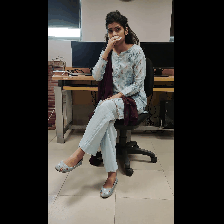

In [12]:
sample_video = frames_from_video_file(file_paths[578], n_frames=10)
print(sample_video.shape)
to_gif(sample_video)

In [13]:
features = []

for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames=10))

features = np.array(features)
gc.collect()

 96%|█████████▋| 766/794 [12:13<00:22,  1.24it/s]

Error reading frame from /content/drive/MyDrive/Human Activity Recognition - Video Dataset/Clapping/Clapping (64).mp4


100%|██████████| 794/794 [12:33<00:00,  1.05it/s]


16

In [14]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(batchSize * 4).batch(batchSize).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(batchSize).cache().prefetch(tf.data.AUTOTUNE)

In [12]:
del train_features
del val_features
gc.collect()

0

In [13]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [20]:
!pip install pydot pydotplus graphviz


In [21]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os


try:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    print("Running on TPU: ", tpu_address)
except KeyError:

    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU not found, running on CPU/GPU.")

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

print("TPU/CPU/GPU initialized!")

TPU not found, running on CPU/GPU.
TPU/CPU/GPU initialized!


In [22]:
import tensorflow as tf
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU successfully initialized!")
except ValueError as e:
    print(f"TPU not detected: {e}")


TPU successfully initialized!


In [23]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(10, 224, 224, 3)),
        tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling3D(),
        tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling3D(),
        tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling3D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.GlobalAveragePooling3D(),
        tf.keras.layers.Dense(len(categories), activation="softmax")
    ])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=["accuracy"]
    )
    model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=valid_ds,
    callbacks=[checkpoint]
)

model.load_weights("model.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 10, 224, 224, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 5, 112, 112, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 2, 56, 56, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 56, 56, 128)    221312    
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
20/20 [==============================] - 34s 2s/step - loss: 1.5296 - accuracy: 0.2929 - val_loss: 1.4252 - val_accuracy: 0.4151
Epoch 3/30
20/20 [==============================] - 33s 2s/step - loss: 1.3063 - accuracy: 0.3890 - val_loss: 1.1595 - val_accuracy: 0.4843
Epoch 4/30
20/20 [==============================] - 32s 2s/step - loss: 1.0925 - accuracy: 0.4835 - val_loss: 1.0365 - val_accuracy: 0.5094
Epoch 5/30
20/20 [==============================] - 33s 2s/step - loss: 0.9888 - accuracy: 0.5591 - val_loss: 0.9111 - val_accuracy: 0.5723
Epoch 6/30
20/20 [==============================] - 33s 2s/step - loss: 0.9104 - accuracy: 0.6000 - val_loss: 0.8848 - val_accuracy: 0.5472
Epoch 7/30
20/20 [==============================] - 32s 2s/step - loss: 0.8469 - accuracy: 0.6299 - val_loss: 0.8394 - val_accuracy: 0.5597
Epoch 8/30
20/20 [==============================] - 32s 2s/step - loss: 0.7930 - accuracy: 0.6598 - val_loss: 0.8052 - val_accuracy: 0.6289
Epoch 9/30
20/20 [==

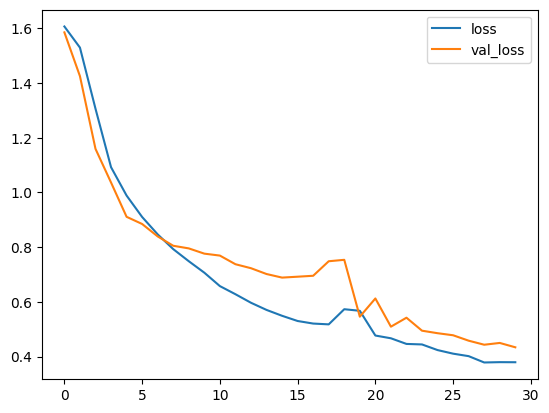

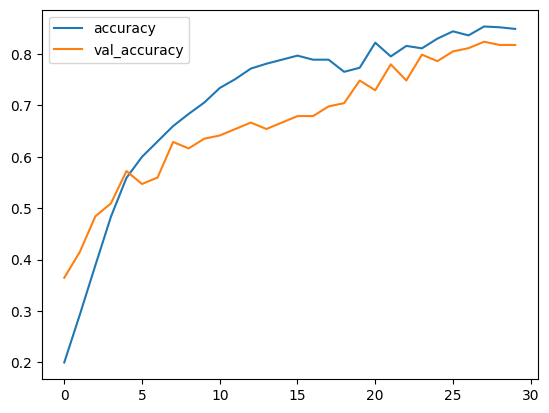

5/5 [==============================] - 7s 1s/step - loss: 0.4435 - accuracy: 0.8239
Validation Loss: 0.44347190856933594 Validation Accuracy: 0.8238993883132935


In [24]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")


In [1]:
!pip install scikit-learn matplotlib tensorflow


1/1 [==============================] - 10s 10s/step


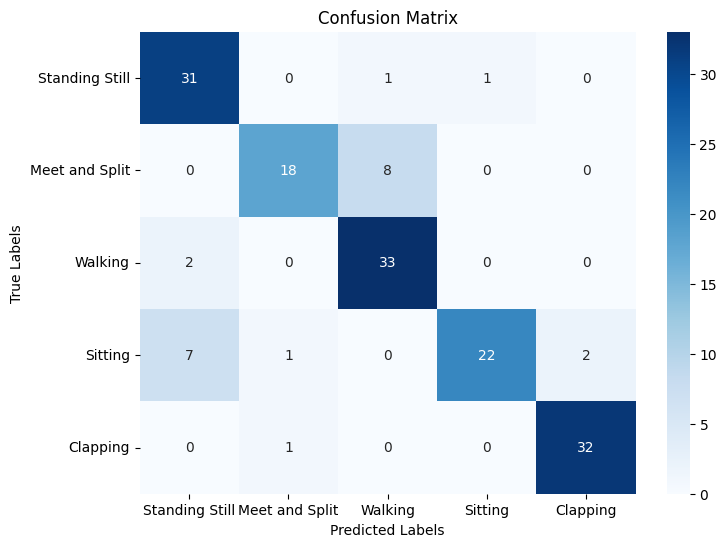

Classification Report:
                 precision    recall  f1-score   support

Standing Still       0.78      0.94      0.85        33
Meet and Split       0.90      0.69      0.78        26
       Walking       0.79      0.94      0.86        35
       Sitting       0.96      0.69      0.80        32
      Clapping       0.94      0.97      0.96        33

      accuracy                           0.86       159
     macro avg       0.87      0.85      0.85       159
  weighted avg       0.87      0.86      0.85       159

5/5 [==============================] - 49s 10s/step


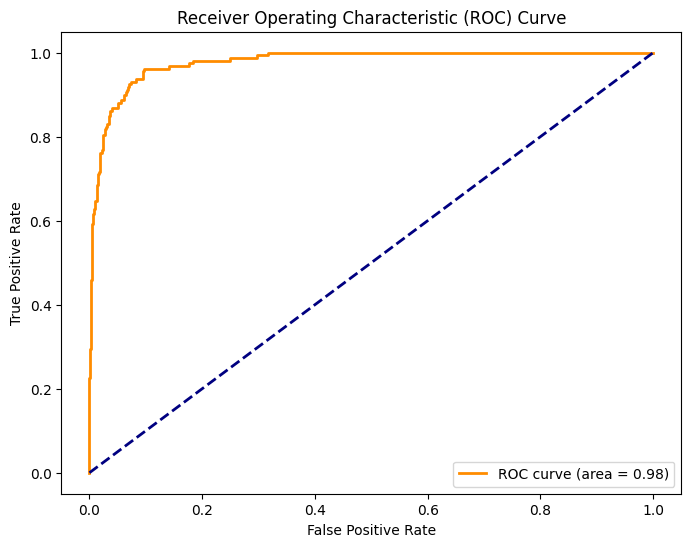

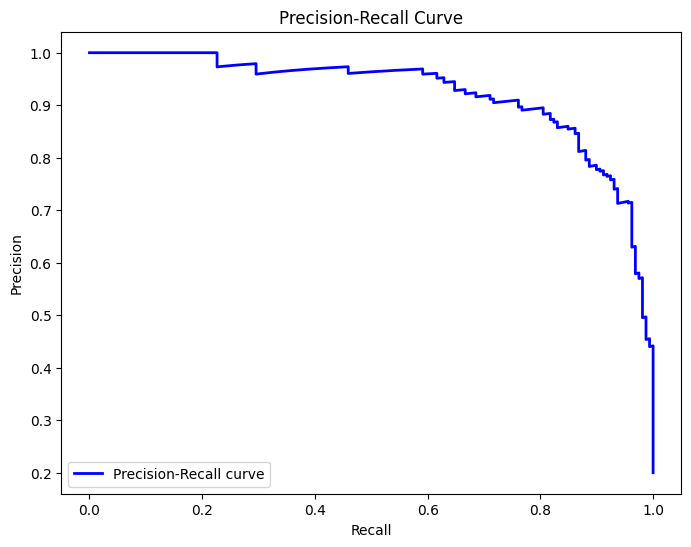

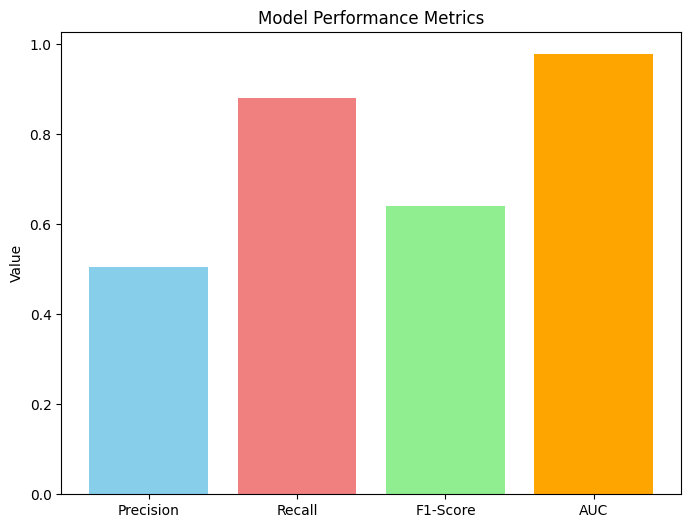

In [17]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve

model = tf.keras.models.load_model('/content/model.h5')

y_true = []
y_pred = []

for images, labels in valid_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=-1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, target_names=categories)
print("Classification Report:\n", report)

y_true_bin = LabelBinarizer().fit_transform(y_true)
y_pred_prob = model.predict(valid_ds, verbose=1)

fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


precision_value = np.mean(precision)
recall_value = np.mean(recall)
f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value)

metrics = {
    'Precision': precision_value,
    'Recall': recall_value,
    'F1-Score': f1_score_value,
    'AUC': roc_auc
}


plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()

